In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# get ANOVA table as R like output
import statsmodels.api as sm
from statsmodels.formula.api import ols
# post-hoc tests:
from bioinfokit.analys import stat
from scipy.stats import ttest_rel
import math

# helper function
# function to calculate Cohen's d for independent samples
def cohend(d1, d2):
    # calculate the size of samples
    n1, n2 = len(d1), len(d2)
    # calculate the variance of the samples
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
    # calculate the pooled standard deviation
    s = math.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # calculate the means of the samples
    u1, u2 = np.mean(d1), np.mean(d2)
    # calculate the effect size
    return (u1 - u2) / s

## 1. Loading the data

Data is available from the EDMOND repository [Modulation of behavior in zebrafish by the neuropeptide PTH2](https://dx.doi.org/10.17617/3.6v). Individual data files should be placed within the same folder as the scripts, otherwise, file locations need to be updated in the cell below. 

The _social preference_ dataframe contains 5 columns: 
- **experiment** either _tripartite_ or _uchamber_, indicating whether the data was obtained in the open field or the forced-choice paradigm.
- **genotype**: either _wt_ (for $pth2^{+/+}$) or _ko_ (fo $pth2^{-/-}$).
- **rearing** either _social_ (rearing in groups of defined size as of 3 days post fertilization) or _isolated_ (rearing alone as of 3 dpf).
- **age**: either 21 or 56 dpf.
- **value**: number between -1 and 1, indicating the social preference index.

In [2]:
df = pd.read_excel(r'.\SocialPreference.xlsx' , sheet_name = 'import')
df.head()

,experiment,genotype,rearing,condition,age,value,replicate
0,tripartite,wt,social,habituation,21,0.987041,1
1,tripartite,wt,social,habituation,21,0.465862,1
2,tripartite,wt,social,habituation,21,0.534656,1
3,tripartite,wt,social,habituation,21,-0.175865,1
4,tripartite,wt,social,habituation,21,-0.165197,1


## Figure 3 b - d and f - h

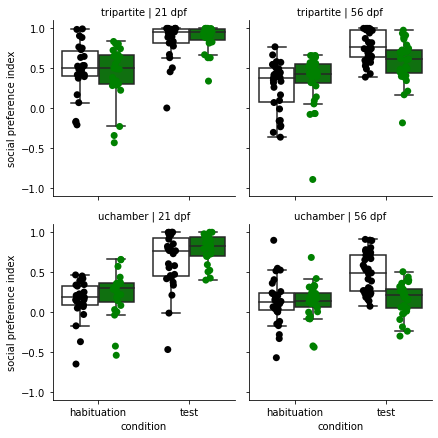

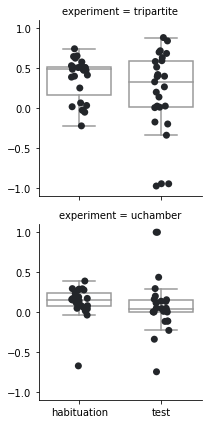

In [3]:
g = sns.FacetGrid(data = df[df['rearing']=='social'], col = 'age' , row = 'experiment')
g.map_dataframe(sns.boxplot , x = 'condition', y = 'value' , hue = 'genotype' , showfliers = 0, palette = ['w', 'g'])
g.map_dataframe(sns.stripplot , x = 'condition' , y = 'value' , hue = 'genotype' , size = 7, dodge = True ,  palette = ['k', 'g'])
g.set_axis_labels("condition", "social preference index")
g.set_titles(col_template="{col_name} dpf", row_template="{row_name}")
g.set(ylim=(-1.1, 1.1))

f = sns.FacetGrid(data = df[df['rearing']=='isolated'], row = 'experiment')
f.map_dataframe(sns.boxplot , x = 'condition', y = 'value' , hue = 'genotype' , showfliers = 0, palette = ['w'])
f.map_dataframe(sns.stripplot , x = 'condition' , y = 'value' , hue = 'genotype' , size = 7, dodge = True)
f.set(ylim=(-1.1, 1.1))

In [11]:
# Statistical Evaluation

df_uchamber = df[df['experiment'] == 'uchamber']
df_uchamber_21 = df_uchamber[df_uchamber['age'] == 21]
df_uchamber_56 = df_uchamber[df_uchamber['age'] == 56]
df_uchamber_56_social = df_uchamber_56[df_uchamber_56['rearing'] == "social"]
df_uchamber_56_iso = df_uchamber_56[df_uchamber_56['rearing'] == "isolated"]

df_tripartite = df[df['experiment'] == 'tripartite']
df_tripartite_21 = df_tripartite[df_tripartite['age'] == 21]
df_tripartite_56 = df_tripartite[df_tripartite['age'] == 56]
df_tripartite_56_social = df_tripartite_56[df_tripartite_56['rearing'] == "social"]
df_tripartite_56_iso = df_tripartite_56[df_tripartite_56['rearing'] == "isolated"]

# for 21 dpf, u-chamber paradigm:
# Ordinary Least Squares (OLS) model
model = ols('value ~ genotype * condition', data=df_uchamber_21).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

#np.sum(df_uchamber_21["genotype"] == "ko")/2

,sum_sq,df,F,PR(>F)
genotype,0.305371,1.0,4.048050,4.691215e-02
condition,7.017329,1.0,93.022867,5.949233e-16
genotype:condition,0.018704,1.0,0.247949,6.196164e-01
Residual,7.543660,100.0,NaN,NaN


In [16]:
# perform multiple pairwise comparison (Tukey's HSD)
# for unequal sample size data, tukey_hsd uses Tukey-Kramer test
res = stat()
res.tukey_hsd(df=df_uchamber_21, res_var='value', xfac_var=['genotype', 'condition'], anova_model='value ~ genotype * condition')
res.tukey_summary

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,"(wt, habituation)","(wt, test)",0.494684,0.302884,0.686485,9.530510,0.001000
1,"(wt, habituation)","(ko, habituation)",0.081795,-0.117837,0.281428,1.514032,0.685560
2,"(wt, habituation)","(ko, test)",0.630282,0.430650,0.829915,11.666539,0.001000
3,"(wt, test)","(ko, habituation)",0.412889,0.213257,0.612522,7.642586,0.001000
4,"(wt, test)","(ko, test)",0.135598,-0.064034,0.335230,2.509921,0.291721
5,"(ko, habituation)","(ko, test)",0.548487,0.341319,0.755655,9.783201,0.001000


In [23]:
# for 21 dpf, open-field paradigm:
# Ordinary Least Squares (OLS) model
model = ols('value ~ genotype * condition', data=df_tripartite_21).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
genotype,0.000062,1.0,0.000789,9.776438e-01
condition,4.173548,1.0,53.408167,7.355500e-11
genotype:condition,0.036704,1.0,0.469690,4.947480e-01
Residual,7.658149,98.0,NaN,NaN


In [17]:
# perform multiple pairwise comparison (Tukey's HSD)
# for unequal sample size data, tukey_hsd uses Tukey-Kramer test
res = stat()
res.tukey_hsd(df=df_tripartite_21, res_var='value', xfac_var=['genotype', 'condition'], anova_model='value ~ genotype * condition')
res.tukey_summary

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,"(wt, habituation)","(wt, test)",0.367358,0.164706,0.570009,6.700803,0.001
1,"(wt, habituation)","(ko, habituation)",0.039502,-0.165166,0.244170,0.713434,0.900
2,"(wt, habituation)","(ko, test)",0.403748,0.199080,0.608416,7.292028,0.001
3,"(wt, test)","(ko, habituation)",0.406859,0.202191,0.611527,7.348217,0.001
4,"(wt, test)","(ko, test)",0.036391,-0.168277,0.241059,0.657244,0.900
5,"(ko, habituation)","(ko, test)",0.443250,0.236585,0.649915,7.928112,0.001


In [18]:
# for 56 dpf, socially reared, u-chamber paradigm:
# Ordinary Least Squares (OLS) model
model = ols('value ~ genotype * condition', data=df_uchamber_56_social).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table


,sum_sq,df,F,PR(>F)
genotype,0.802448,1.0,13.943127,0.000288
condition,1.174282,1.0,20.404020,0.000015
genotype:condition,0.799345,1.0,13.889214,0.000295
Residual,7.021286,122.0,NaN,NaN


In [33]:
# perform multiple pairwise comparison (Tukey's HSD)
# for unequal sample size data, tukey_hsd uses Tukey-Kramer test
res = stat()
res.tukey_hsd(df=df_uchamber_56_social, res_var='value', xfac_var=['genotype', 'condition'], anova_model='value ~ genotype * condition')
res.tukey_summary



,group1,group2,Diff,Lower,Upper,q-value,p-value
0,"(wt, habituation)","(wt, test)",0.349867,0.193634,0.506100,8.249917,0.001
1,"(wt, habituation)","(ko, habituation)",0.000309,-0.157179,0.157796,0.007226,0.900
2,"(wt, habituation)","(ko, test)",0.030921,-0.126567,0.188408,0.723306,0.900
3,"(wt, test)","(ko, habituation)",0.350176,0.192688,0.507663,8.191406,0.001
4,"(wt, test)","(ko, test)",0.318946,0.161459,0.476434,7.460873,0.001
5,"(ko, habituation)","(ko, test)",0.031230,-0.127503,0.189962,0.724803,0.900


In [28]:
# for 56 dpf, reared in isolation, forced-choice paradigm:
ttest_rel(df_uchamber_56_iso[df_uchamber_56_iso['condition'] == 'habituation']['value'] , 
               df_uchamber_56_iso[df_uchamber_56_iso['condition'] == 'test']['value'])

cohend(df_uchamber_56_iso[df_uchamber_56_iso['condition'] == 'habituation']['value'] , 
               df_uchamber_56_iso[df_uchamber_56_iso['condition'] == 'test']['value'])

np.mean(df_uchamber_56_iso[df_uchamber_56_iso['condition'] == 'test']['value'])

0.08517424037339551

In [49]:
# for 56 dpf, open-field paradigm:
# Ordinary Least Squares (OLS) model
model = ols('value ~ genotype * condition', data=df_tripartite_56_social).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table
wt_56 = df_tripartite_56_social[df_tripartite_56_social["genotype"] == "wt"]
ko_56 = df_tripartite_56_social[df_tripartite_56_social["genotype"] == "ko"]

cohend(ko_56[ko_56["condition"]=="habituation"]["value"],
      ko_56[ko_56["condition"]=="test"]["value"])

-0.8218164106079229

In [22]:
# perform multiple pairwise comparison (Tukey's HSD)
# for unequal sample size data, tukey_hsd uses Tukey-Kramer test
res = stat()
res.tukey_hsd(df=df_tripartite_56_social, res_var='value', xfac_var=['genotype', 'condition'], anova_model='value ~ genotype * condition')
res.tukey_summary

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,"(wt, habituation)","(wt, test)",0.495737,0.315859,0.675616,10.152897,0.001000
1,"(wt, habituation)","(ko, habituation)",0.074368,-0.104100,0.252836,1.535125,0.677085
2,"(wt, habituation)","(ko, test)",0.309242,0.130774,0.487710,6.383466,0.001000
3,"(wt, test)","(ko, habituation)",0.421369,0.242901,0.599837,8.698033,0.001000
4,"(wt, test)","(ko, test)",0.186495,0.008027,0.364963,3.849693,0.036886
5,"(ko, habituation)","(ko, test)",0.234874,0.057828,0.411920,4.887283,0.004160


In [52]:
# for 56 dpf, reared in isolation, open-field paradigm:
ttest_rel(df_tripartite_56_iso[df_tripartite_56_iso['condition'] == 'habituation']['value'] , 
               df_tripartite_56_iso[df_tripartite_56_iso['condition'] == 'test']['value'])

Ttest_relResult(statistic=2.056743452618159, pvalue=0.04987449506356395)

In [53]:
# Effect sizes and central tendencies

# Tripartite chamber, 21 dpf: 0.12
print('Tripartite, 21 dpf, effect size (Cohen) for wildtype: ')
print(cohend(df_tripartite_21[df_tripartite_21['condition'] == 'habituation'][df_tripartite_21[df_tripartite_21['condition'] == 'habituation']['genotype']=='wt']['value'],
       df_tripartite_21[df_tripartite_21['condition'] == 'test'][df_tripartite_21[df_tripartite_21['condition'] == 'test']['genotype']=='wt']['value']))
print('Tripartite, 21 dpf, effect size (Cohen) for mutants: ')
print(cohend(df_tripartite_21[df_tripartite_21['condition'] == 'habituation'][df_tripartite_21[df_tripartite_21['condition'] == 'habituation']['genotype']=='ko']['value'],
       df_tripartite_21[df_tripartite_21['condition'] == 'test'][df_tripartite_21[df_tripartite_21['condition'] == 'test']['genotype']=='ko']['value']))

print('\n')
print('median of wildtype in this experiment, habituation: ')
print(np.median(df_tripartite_21[df_tripartite_21['condition'] == 'habituation'][df_tripartite_21[df_tripartite_21['condition'] == 'habituation']['genotype']=='wt']['value']))
print('median of wildtype in this experiment, test: ')
print(np.median(df_tripartite_21[df_tripartite_21['condition'] == 'test'][df_tripartite_21[df_tripartite_21['condition'] == 'test']['genotype']=='wt']['value']))
print('\n')

print('median of mutants in this experiment, habituation: ')
print(np.median(df_tripartite_21[df_tripartite_21['condition'] == 'habituation'][df_tripartite_21[df_tripartite_21['condition'] == 'habituation']['genotype']=='ko']['value']))
print('median of mutants in this experiment, test: ')
print(np.median(df_tripartite_21[df_tripartite_21['condition'] == 'test'][df_tripartite_21[df_tripartite_21['condition'] == 'test']['genotype']=='ko']['value']))
print('\n')
print('----------------------')

# U-chamber, 21 dpf: 0.49
print('U-chamber, 21 dpf, effect size (Cohen) for wildtype: ')
print(cohend(df_uchamber_21[df_uchamber_21['condition'] == 'habituation'][df_uchamber_21[df_uchamber_21['condition'] == 'habituation']['genotype']=='wt']['value'],
       df_uchamber_21[df_uchamber_21['condition'] == 'test'][df_uchamber_21[df_uchamber_21['condition'] == 'test']['genotype']=='wt']['value']))
print('U-chamber, 21 dpf, effect size (Cohen) for mutants: ')
print(cohend(df_uchamber_21[df_uchamber_21['condition'] == 'habituation'][df_uchamber_21[df_uchamber_21['condition'] == 'habituation']['genotype']=='ko']['value'],
       df_uchamber_21[df_uchamber_21['condition'] == 'test'][df_uchamber_21[df_uchamber_21['condition'] == 'test']['genotype']=='ko']['value']))

print('\n')
print('median of wildtype in this experiment, habituation: ')
print(np.median(df_uchamber_21[df_uchamber_21['condition'] == 'habituation'][df_uchamber_21[df_uchamber_21['condition'] == 'habituation']['genotype']=='wt']['value']))
print('median of wildtype in this experiment, test: ')
print(np.median(df_uchamber_21[df_uchamber_21['condition'] == 'test'][df_uchamber_21[df_uchamber_21['condition'] == 'test']['genotype']=='wt']['value']))
print('\n')

print('median of mutant in this experiment, habituation: ')
print(np.median(df_uchamber_21[df_uchamber_21['condition'] == 'habituation'][df_uchamber_21[df_uchamber_21['condition'] == 'habituation']['genotype']=='ko']['value']))
print('median of mutant in this experiment, test: ')
print(np.median(df_uchamber_21[df_uchamber_21['condition'] == 'test'][df_uchamber_21[df_uchamber_21['condition'] == 'test']['genotype']=='ko']['value']))
print('\n')
print('----------------------')

# Tripartite chamber, 56 dpf: 0.23
print('Tripartite, 56 dpf, effect size (Cohen) for wildtype: ')
print(cohend(df_tripartite_56[df_tripartite_56['condition'] == 'habituation'][df_tripartite_56[df_tripartite_56['condition'] == 'habituation']['genotype']=='wt']['value'],
             df_tripartite_56[df_tripartite_56['condition'] == 'test'][df_tripartite_56[df_tripartite_56['condition'] == 'test']['genotype']=='wt']['value']))

print('Tripartite, 56 dpf, effect size (Cohen) for mutants: ')
print(cohend(df_tripartite_56[df_tripartite_56['condition'] == 'habituation'][df_tripartite_56[df_tripartite_56['condition'] == 'habituation']['genotype']=='ko']['value'],
             df_tripartite_56[df_tripartite_56['condition'] == 'test'][df_tripartite_56[df_tripartite_56['condition'] == 'test']['genotype']=='ko']['value']))

print('\n')

print('median of wildtype in this experiment, habituation: ')
print(np.median(df_tripartite_56[df_tripartite_56['condition'] == 'habituation'][df_tripartite_56[df_tripartite_56['condition'] == 'habituation']['genotype']=='wt']['value']))
print('median of wildtype in this experiment, test: ')
print(np.median(df_tripartite_56[df_tripartite_56['condition'] == 'test'][df_tripartite_56[df_tripartite_56['condition'] == 'test']['genotype']=='wt']['value']))
print('\n')

print('median of mutant in this experiment, habituation: ')
print(np.median(df_tripartite_56[df_tripartite_56['condition'] == 'habituation'][df_tripartite_56[df_tripartite_56['condition'] == 'habituation']['genotype']=='ko']['value']))

print('median of mutant in this experiment, test: ')
print(np.median(df_tripartite_56[df_tripartite_56['condition'] == 'test'][df_tripartite_56[df_tripartite_56['condition'] == 'test']['genotype']=='ko']['value']))
print('\n')
print('----------------------')

# U-chamber, 56 dpf: 0.57
print('U-chamber, 56 dpf, effect size (Cohen), wildtype: ')
print(cohend(df_uchamber_56[df_uchamber_56['condition'] == 'habituation'][df_uchamber_56[df_uchamber_56['condition'] == 'habituation']['genotype']=='wt']['value'],
       df_uchamber_56[df_uchamber_56['condition'] == 'test'][df_uchamber_56[df_uchamber_56['condition'] == 'test']['genotype']=='wt']['value']))

print('U-chamber, 56 dpf, effect size (Cohen), mutant: ')
print(cohend(df_uchamber_56[df_uchamber_56['condition'] == 'habituation'][df_uchamber_56[df_uchamber_56['condition'] == 'habituation']['genotype']=='ko']['value'],
       df_uchamber_56[df_uchamber_56['condition'] == 'test'][df_uchamber_56[df_uchamber_56['condition'] == 'test']['genotype']=='ko']['value']))
print('\n')

print('median of wildtype in this experiment, habituation: ')
print(np.median(df_uchamber_56[df_uchamber_56['condition'] == 'habituation'][df_uchamber_56[df_uchamber_56['condition'] == 'habituation']['genotype']=='wt']['value']))
print('median of wildtype in this experiment, test: ')
print(np.median(df_uchamber_56[df_uchamber_56['condition'] == 'test'][df_uchamber_56[df_uchamber_56['condition'] == 'test']['genotype']=='wt']['value']))
print('\n')
print('median of mutant in this experiment, habituation: ')
print(np.median(df_uchamber_56[df_uchamber_56['condition'] == 'habituation'][df_uchamber_56[df_uchamber_56['condition'] == 'habituation']['genotype']=='ko']['value']))
print('median of mutant in this experiment, test: ')
print(np.median(df_uchamber_56[df_uchamber_56['condition'] == 'test'][df_uchamber_56[df_uchamber_56['condition'] == 'test']['genotype']=='ko']['value']))
print('\n')
print('----------------------')

# Tripartite chamber, 56 dpf, isolated: 0.75
print('Tripartite, 56 dpf, isolated wildtype, effect size (Cohen): ')
print(cohend(df_tripartite_56_iso[df_tripartite_56_iso['condition'] == 'habituation']['value'],
             df_tripartite_56_iso[df_tripartite_56_iso['condition'] == 'test']['value']))

# U-chamber, 56 dpf, isolated: 0.18
print('U-chamber, 56 dpf, isolated wildtype, effect size (Cohen): ')
print(cohend(df_uchamber_56_iso[df_uchamber_56_iso['condition'] == 'habituation']['value'],
             df_uchamber_56_iso[df_uchamber_56_iso['condition'] == 'test']['value']))

print('\n')
print('median of habituation phase in Tripartite chamber: ')
print(np.median(df_tripartite_56_iso[df_tripartite_56_iso['condition'] == 'habituation']['value']))
print('median of test phase in Tripartite chamber: ')
print(np.median(df_tripartite_56_iso[df_tripartite_56_iso['condition'] == 'test']['value']))
print('\n')
print('median of habituation phase in U-chamber chamber: ')
print(np.median(df_uchamber_56_iso[df_uchamber_56_iso['condition'] == 'habituation']['value']))
print('median of test phase in U-chamber chamber: ')
print(np.median(df_uchamber_56_iso[df_uchamber_56_iso['condition'] == 'test']['value']))

Tripartite, 21 dpf, effect size (Cohen) for wildtype: 
-1.2792188510232005
Tripartite, 21 dpf, effect size (Cohen) for mutants: 
-1.633396559800913


median of wildtype in this experiment, habituation: 
0.50895
median of wildtype in this experiment, test: 
0.9527000000000001


median of mutants in this experiment, habituation: 
0.5038
median of mutants in this experiment, test: 
0.9597


----------------------
U-chamber, 21 dpf, effect size (Cohen) for wildtype: 
-1.6430212990742956
U-chamber, 21 dpf, effect size (Cohen) for mutants: 
-2.2858218810896953


median of wildtype in this experiment, habituation: 
0.18684562189791803
median of wildtype in this experiment, test: 
0.7688329087956234


median of mutant in this experiment, habituation: 
0.30625
median of mutant in this experiment, test: 
0.8236405822869207


----------------------
Tripartite, 56 dpf, effect size (Cohen) for wildtype: 
-0.45931394819238014
Tripartite, 56 dpf, effect size (Cohen) for mutants: 
-0.8218164106079229


In [59]:
df_tripartite_56_iso


,experiment,genotype,rearing,condition,age,value
50,tripartite,wt,isolated,habituation,56,0.065678
51,tripartite,wt,isolated,habituation,56,-0.050592
52,tripartite,wt,isolated,habituation,56,0.252875
53,tripartite,wt,isolated,habituation,56,0.033922
54,tripartite,wt,isolated,habituation,56,-0.024671
55,tripartite,wt,isolated,habituation,56,-0.025754
56,tripartite,wt,isolated,habituation,56,-0.221870
57,tripartite,wt,isolated,habituation,56,0.018086
58,tripartite,wt,isolated,test,56,-0.975496
59,tripartite,wt,isolated,test,56,-0.338806
